## Kalman Filtering


In [102]:
import Simulator
import Observation
import Statistics
import LETKalmanFilter

### Definition of forward model

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators



In [103]:
timestamp = "2021_07_29-12_52_15"

grid, simulator = Simulator.from_file(timestamp)

### Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [104]:
import numpy as np

def prior(grid, phi):
    """
    Constructing a Matern-type covariance prior with Matern-parameter phi
    where the matrix is normalized with the standard deviation
    """
    # INPUT! Bell mean
    mean = 0.0*np.ones(grid.N_x)
    # INPUT! Constant var
    var  = 0.5*np.ones(grid.N_x)

    # Matern covariance
    dist_mat = np.copy(grid.dist_mat)
    cov = (1+phi*dist_mat)*np.exp(-phi*dist_mat)
    
    # Normalisation
    var_mesh = np.meshgrid(np.sqrt(var),np.sqrt(var))[0]*np.meshgrid(np.sqrt(var),np.sqrt(var))[1]    

    return mean, var_mesh, cov

Please remember to set priors!


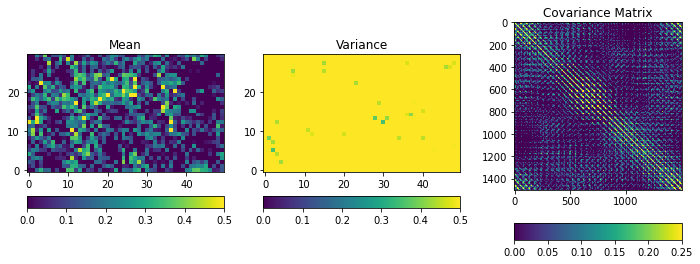

In [105]:
statistics = Statistics.Statistics(simulator, 25)
mean, var_mesh, cov = prior(grid=grid, phi=5.0)
statistics.set(mean, var_mesh*cov, nugget=0.5)
statistics.plot()

### Observations

In [106]:
observation = Observation.from_file(simulator)

Remember to set observation positions and to set values!


In [107]:
from matplotlib import pyplot as plt

In [108]:
letkFilter = LETKalmanFilter.LETKalman(statistics, observation, 5)

In [109]:
idx = 0

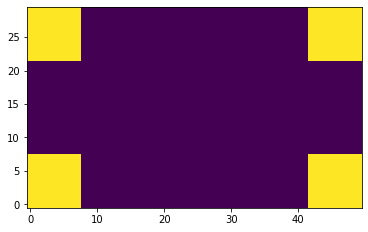

In [110]:
plt.imshow(letkFilter.all_Ls[idx], origin="lower")

In [111]:
X_f = np.zeros((statistics.ensemble.N_e, grid.ny, grid.nx))
for e in range(X_f.shape[0]):
    X_f[e] = np.reshape(statistics.ensemble.ensemble[:,e], (grid.ny, grid.nx))

In [112]:
X_f_mean = np.average(X_f, axis=0)
X_f_pert = X_f - X_f_mean

In [113]:
X_a = np.zeros_like(X_f)

In [114]:
N_x_local = letkFilter.W_loc.shape[0]*letkFilter.W_loc.shape[1] 

L = letkFilter.all_Ls[idx]
xroll = letkFilter.all_xrolls[idx]
yroll = letkFilter.all_yrolls[idx]

In [115]:
X_f_loc = np.zeros((statistics.ensemble.N_e, N_x_local))
X_f_loc[:,:] = X_f[:,L]          

In [116]:
X_f_loc_pert = np.zeros((statistics.ensemble.N_e, N_x_local))
X_f_loc_pert[:,:] = X_f_pert[:,L]

In [117]:
X_f_loc_mean = np.zeros((N_x_local))
X_f_loc_mean[:] = X_f_mean[L]

In [118]:
if not (xroll == 0 and yroll == 0):
    rolling_shape = (statistics.ensemble.N_e, letkFilter.W_loc.shape[0], letkFilter.W_loc.shape[1]) # roll around axis 2 and 3
    X_f_loc[:,:] = np.roll(np.roll(X_f_loc.reshape(rolling_shape), shift=-yroll, axis=1 ), shift=-xroll, axis=2).reshape((statistics.ensemble.N_e, N_x_local))
    X_f_loc_pert[:,:] = np.roll(np.roll(X_f_loc_pert.reshape(rolling_shape), shift=-yroll, axis=1 ), shift=-xroll, axis=2).reshape((statistics.ensemble.N_e, N_x_local))

    mean_rolling_shape = (letkFilter.W_loc.shape[0], letkFilter.W_loc.shape[1]) # roll around axis 1 and 2
    X_f_loc_mean[:] = np.roll(np.roll(X_f_loc_mean.reshape(mean_rolling_shape), shift=-yroll, axis=0 ), shift=-xroll, axis=1).reshape((N_x_local))

In [163]:
X_f_loc = X_f_loc.T
X_f_loc_pert = X_f_loc_pert.T

In [132]:
HX_f = observation.H @ statistics.ensemble.ensemble
HX_f_mean = np.average(HX_f, axis=1)
HX_f_pert = HX_f - np.reshape(HX_f_mean, (observation.N_y,1))

In [139]:
HX_f_loc_mean = HX_f_mean[idx]
HX_f_loc_pert = HX_f_pert[idx,:]

In [144]:
Rinv = 1/observation.noise[idx,idx]

In [149]:
y_loc = observation.obses[0][idx]

In [152]:
D = y_loc - HX_f_loc_mean

In [154]:
A1 = (statistics.ensemble.N_e-1)*np.eye(statistics.ensemble.N_e)
A2 = np.dot(HX_f_loc_pert.T, np.dot(Rinv, HX_f_loc_pert))
A = A1 + A2
P = np.linalg.inv(A)

In [164]:
K = np.dot(X_f_loc_pert, np.dot(P, np.dot(HX_f_loc_pert.T, Rinv)))

In [165]:
X_a_loc_mean = X_f_loc_mean + np.dot(K, D)

In [166]:
sigma, V = np.linalg.eigh( (statistics.ensemble.N_e - 1) * P )

In [167]:
X_a_loc_pert = np.dot( X_f_loc_pert, np.dot( V, np.dot( np.diag( np.sqrt( np.real(sigma) ) ), V.T )))

In [169]:
X_a_loc = np.reshape(X_a_loc_mean,(N_x_local,1)) + X_a_loc_pert

In [120]:
# Calculate weighted local analysis
weighted_X_a_loc = X_a_loc[:,:]*(np.tile(letkFilter.W_loc.flatten().T, (statistics.ensemble.N_e, 1)).T)
# Here, we use np.tile(W_loc.flatten().T, (N_e_active, 1)).T to repeat W_loc as column vector N_e_active times 

if not (xroll == 0 and yroll == 0):
    weighted_X_a_loc = np.roll(np.roll(weighted_X_a_loc[:,:].reshape((letkFilter.W_loc.shape[0], letkFilter.W_loc.shape[1], statistics.ensemble.N_e)), 
                                                                    shift=yroll, axis=0 ), 
                                    shift=xroll, axis=1)

X_a[:,L] += weighted_X_a_loc.reshape(letkFilter.W_loc.shape[0]*letkFilter.W_loc.shape[1], statistics.ensemble.N_e).T

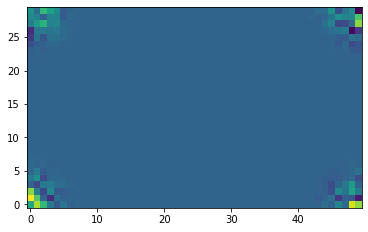

In [121]:
plt.imshow(X_a[0], origin="lower")

In [122]:
X_new = np.zeros_like(X_a)
for e in range(statistics.ensemble.N_e):
    X_new[e] = letkFilter.W_forecast*X_f[e] + X_a[e]

(1500, 25)


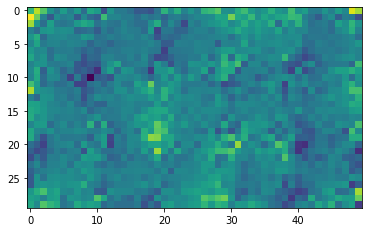

In [123]:
X_new = np.reshape(X_new, (25,1500)).T
print(X_new.shape)
plt.imshow(np.reshape(X_new[:,0], (grid.ny, grid.nx)))